In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import lbg_forecast.hyperparams as hyp
import lbg_forecast.priors as pr
import lbg_forecast.popmodel as pop
import lbg_forecast.emulator as em
import lbg_forecast.tools as tools
import lbg_forecast.nz_sim as nz
import numpy as np
import matplotlib.pyplot as plt

2024-01-11 12:58:05.184361: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-11 12:58:05.184376: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-11 12:58:05.184380: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-11 12:58:05.184412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-11 12:58:05.184428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# initalise fsps emulator
model = em.fsps_emulator()
sps_params = model._sps_params

In [4]:
dz, dlogm = 0.1, 0.05
z_min, z_max = 0.0, 15.0
logm_min, logm_max = 7.0, 13.0
grid_params = np.array([dz, dlogm, z_min, z_max, logm_min, logm_max])
z_grid, logm_grid = pr.setup_grids(grid_params)

n_priors_samples = 100
priors = pr.load_priors(z_grid, logm_grid, n_priors_samples, init_sample=10000)
prior_params = [z_grid, logm_grid, priors, grid_params]

In [5]:
hyper_param_bounds = hyp.define_hyperparameter_bounds( 
                           
    zred = np.array([n_priors_samples, 0, 7]),
    logtage = np.array([1, -3, 1]),
    logzsol = np.array([1, -2.5, 0.5]),
    dust1 = np.array([0, 0, 0]),
    dust2 = np.array([1, 0, 2]),
    igm_factor = np.array([0, 1, 1]), 
    gas_logu = np.array([1, -4, -1]),
    logfagn = np.array([0, 0, 0]),
    imf1 = np.array([0, 1.3, 1.3]), 
    imf2 = np.array([0, 2.3, 2.3]), 
    imf3 = np.array([0, 2.3, 2.3]), 
    tau = np.array([1, 1e-3, 1]),
    loga = np.array([1, -3, 1]),
    logb = np.array([1, -3, 1]),
    logmass = np.array([n_priors_samples, 7, 13])

    )

In [6]:
nhyperparams = 100
hyperparameters = hyp.sample_nhyperparameters(hyper_param_bounds, nhyperparams)

In [7]:
# nz histogram parameters
dz = 0.1
minz = 0.0
maxz = 7.0

bins = np.arange(minz, maxz, dz)

nz_data = []
sps_params_list = []
nsamples = 20
ngalaxies = 2000000
i = 0
while(i<nsamples):
    sps_params = pop.galaxy_population_model_vec(hyperparameters[np.random.randint(0, nhyperparams)], prior_params, ngalaxies)
    print("run ", i, ":", "SPS Parameters Generated")
    nzs = nz.simulate_nzs(sps_params, model, bins)
    print("run ", i, ":", "N(z)'s Generated")
    sps_params_list.append(sps_params)
    nz_data.append(nzs)
    i+=1

KeyboardInterrupt: 

In [ ]:
#tools.plot_galaxy_population(sps_params_list[9])

In [ ]:
def plot_realisation(realisation, nz_data, bins, alpha):
    
    plt.bar(bins[:-1], nz_data[realisation][0], width=np.diff(bins), edgecolor="black", align="edge", alpha=alpha, lw=0.5, color = 'blue')
    plt.bar(bins[:-1], nz_data[realisation][1], width=np.diff(bins), edgecolor="black", align="edge", alpha=alpha, lw=0.5, color = 'red')
    plt.bar(bins[:-1], nz_data[realisation][2], width=np.diff(bins), edgecolor="black", align="edge", alpha=alpha, lw=0.5, color = 'green' )

def plot_realisations(nsamples, nz_data, bins, alpha):

    i = 0
    while(i < nsamples):
        plot_realisation(i, nz_data, bins, alpha)
        i+=1

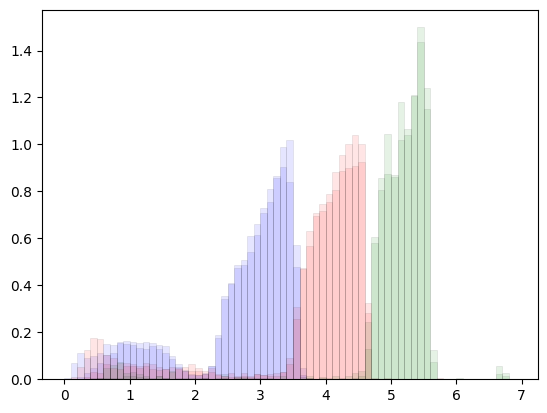

In [ ]:
plot_realisations(nsamples, nz_data, bins, 0.1)